# Previsão como Modelos Autoregressivos Univariados

### - ARMA
### - ARIMA
### - SARIMA
### - SARIMAX

In [1]:
import pandas as pd
from pandas import Grouper, DataFrame

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime
import random
import time

from matplotlib import pyplot as plt
import seaborn as sns

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

## Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 10

MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

## Funções

In [7]:
def split_train_test_window_dataset(full_dataset: np.ndarray, test_percentual_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Separa os dados em treino, teste para modelos autoregressivos. 
        Não existe o conceito de janela que será utilizado nos modelos de suavização e Redes Neurais
        
        Args:
            full_dataset (ndarray): datafame contendo a série de desembolso
            test_percentual_size (int): percentual de dados para teste
            
        Returns:
            1) y_train - Label para treino, será descartado para modelos autoregressivos.
            2) X_test - Feature, desembolsos anteriores ao previsto. Cada item dessa array contém todos os desembolsos anteriores ao que será previsto. O desembolso real estará no terceiro valor retornado.
            3) y_test - Label da base de teste, será utilizado para avaliação da previsão
    """
    
    dataset_size: int = full_dataset.shape[0]
    cut_pos: int = round(dataset_size - (dataset_size * (test_percentual_size /100)))
    test_dataset_size: int = dataset_size - cut_pos
    
    y_train: np.ndarray = full_dataset[0 : cut_pos]
    y_test: np.ndarray = full_dataset[cut_pos:]
    
    #train_dataset_list = [full_dataset[0 : ind] for ind in range (cut_pos)]
    #X_train = np.array(train_dataset_list)
    
    X_test_list = [full_dataset[0:cut_pos + ind] for ind in range (test_dataset_size)]
    X_test = np.array(X_test_list)
    
    return y_train, X_test, y_test

In [8]:
#Separa os dados em treino, teste (resultdado) para modelos autoregressivos. Não existe o conceito de janela que será utilizado 
# nos modelos de suavização e Redes Neurais
def split_train_test_multivariate_window_dataset(data_frame: pd.DataFrame, 
                                                 feature_columns: List[str], 
                                                 pred_column: str,
                                                 test_percentual_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dataset_size: int = len(data_frame)
    cut_pos: int = round(dataset_size - (dataset_size * (test_percentual_size /100)))
    test_dataset_size: int = dataset_size - cut_pos
    
    X_test: np.ndarray = data_frame[[pred_column]][0 : cut_pos].to_numpy().squeeze()
    y_test: np.ndarray = data_frame[[pred_column]][cut_pos:].to_numpy().squeeze()
    
    #train_dataset_list = [full_dataset[0 : ind] for ind in range (cut_pos)]
    #X_train = np.array(train_dataset_list)

    full_dataset_endogeno: np.ndarray = data_frame[[pred_column]].to_numpy().squeeze()
    full_dataset_exogeno: np.ndarray = data_frame[feature_columns].to_numpy().squeeze()
    
    test_endogeno_dataset_list = [full_dataset_endogeno[0:cut_pos + ind] for ind in range (test_dataset_size)]
    y_train_endogeno = np.array(test_endogeno_dataset_list)
    
    test_exogeno_dataset_list = [full_dataset_exogeno[0:cut_pos + ind] for ind in range (test_dataset_size)]
    y_train_exogeno = np.array(test_exogeno_dataset_list)
        
    return X_test, y_train_endogeno, y_train_exogeno, y_test

## Carrega Datasets

In [9]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

---
## ARIMA - Auto Regressivo, Diferença e Média Móvel
Modelo ARIMA utiliza o conceito de janela, cada dataset de treino contém uma janela com dados anteriores para previsão

In [10]:
y_train, X_test, y_true = split_train_test_window_dataset(desembolso, TEST_SPLIT_SIZE)

C:\Users\gdutr\AppData\Local\Temp/ipykernel_13856/222814096.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test_list)


In [11]:

def grid_search_arima(observations: np.ndarray, y_true: np.ndarray) -> Tuple[float, Tuple[int,int,int]]:
    """
        Busca a melhor configuração de p (ordem autoregressiva), i (ordem da diferença), q (ordem da média móvel)
        
        Args:
            observations (ndarray): features para previsão, ou seja, os desembolsos anteriores ao que será previsto.
            y_true (ndarray): labels, o desembolso que deve ser confrontado com a previsao
    """
    
    best_score:float = -1000000
    best_order: Tuple[int,int,int] = (0,0,0)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for p_range in range(2):  # order for autoregressive
            for q_range in range(15): # order for moving average
                for i_range in range(3): # order for difference
                    prediction_list = []
                    for step in range(len(observations)):
                        try:
                            mod = ARIMA(observations[step], order=(p_range,i_range,q_range))
                            res = mod.fit()
                            prediction_list.append(res.forecast(steps=1))
                        except:
                            print(f'error order({p_range},{i_range},{q_range}')
                            prediction_list.append(-99999999)

                    prediction: np.ndarray = np.array(prediction_list)
                    score = r2_score(y_true, prediction)
                    if score > best_score:
                        best_score = score
                        best_order = (p_range,i_range,q_range)
                        best_prediction = prediction
                        print(f'Best {best_score} com order({best_order})', end = "\r")
                    else:
                        print(f'Não melhorou {score} com order({p_range},{i_range},{q_range}) - Best {best_score} com order({best_order})', end = "\r")
                        
        return best_score, best_order

In [12]:
%time (best_score_arima, best_order_arima) = grid_search_arima(X_test, y_true)
print('\n----------------------------------------------------------------------------------------------')
print(f'Melhor score {best_score_arima} com ordem {best_order_arima}')

Wall time: 7min 22s8061934169345 com order(1,2,14) - Best 0.2699050927764277 com order((0, 2, 11))))

----------------------------------------------------------------------------------------------
Melhor score 0.2699050927764277 com ordem (0, 2, 11)


In [6]:
#best_order = (0,2,11)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    prediction_list = []
    for step in range(len(y_train)):
        mod = ARIMA(y_train[step], order=best_order)
        res = mod.fit()
        prediction_list.append(res.forecast(steps=1))
    arima_prediction = np.array(prediction_list)  


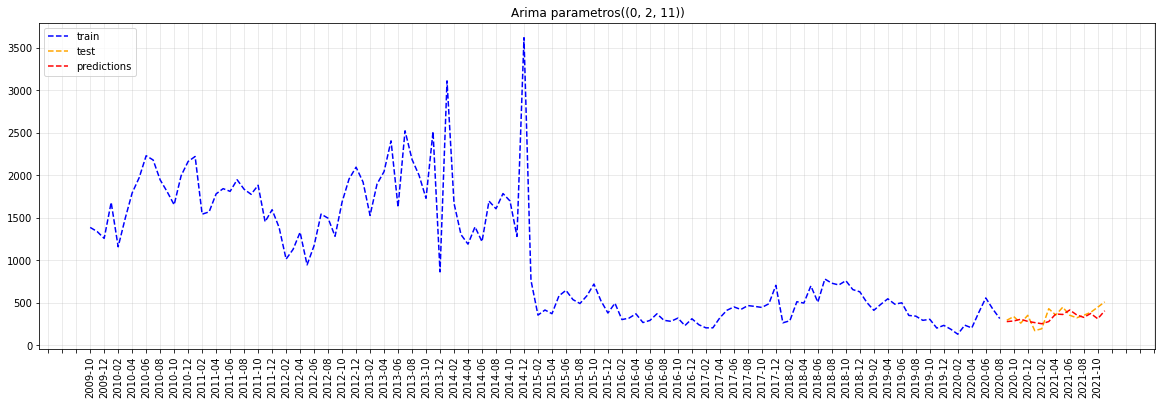

In [7]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(arima_prediction):], arima_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Arima parametros({best_order})")
plt.grid(alpha=0.3);

In [8]:
arima_mse = mean_squared_error(y_true, arima_prediction, squared=True)
arima_mae = mean_absolute_error(y_true, arima_prediction)
arima_r2 = r2_score(y_true, arima_prediction)
print(f'Mean Squared Error: {arima_mse} ')
print(f'Mean Absolute Error: {arima_mae}')
print(f'R2 Score: {arima_r2}')

Mean Squared Error: 5857.794370726033 
Mean Absolute Error: 64.05459963019605
R2 Score: 0.2699050927764277



---
## SARIMA - Inclusão de Sazonalidade


In [6]:
y_train, X_test, y_true = split_train_test_window_dataset(desembolso, TEST_SPLIT_SIZE)

C:\Users\gdutr\AppData\Local\Temp/ipykernel_800/1425785119.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array(test_dataset_list)


In [7]:
def grid_search_sarima(observations: np.ndarray, y_true: np.ndarray) -> Tuple[float, Tuple[int,int,int], Tuple[int,int,int]]:
    best_score = -1000000
    best_order: Tuple[int,int,int] = (0,0,0)
    best_seasonal_order: Tuple[int,int,int] = (0,0,0)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for p in range(2):  # order for autoregressive
            for q in range(12): # order for moving average
                for i in range(2): # order for difference
                    for P in range(2): #order for seasonal AR
                        for Q in range(2): #order for seasonal moving Average
                            for D in range(2): #order for seasonal Difference
                                prediction_list = []
                                start_time = time.time()
                                for step in range(len(observations)):

                                    mod = sm.tsa.statespace.SARIMAX(observations[step], order=(p,i,q), seasonal_order=(P,D,Q,12))
                                    res = mod.fit(disp=False)
                                    prediction_list.append(res.forecast(steps=1))
                                    #except:
                                     #   print(f'error order({p},{i},{q}) | Sorder({P},{D},{Q})')
                                     #   prediction_list.append(-99999999)

                                prediction: np.ndarray = np.array(prediction_list)
                                score = r2_score(y_true, prediction)
                                if score > best_score:
                                    best_score = score
                                    best_order = (p,i,q)
                                    best_seasonal_order = (P,D,Q)
                                    best_prediction = prediction
                                    print(f'Best {best_score} com order({best_order}) e seasonal order({best_seasonal_order}). Tempo de execução {time.time() - start_time} segundos', end = "\r")
                                else:
                                    print(f'Não melhorou {score} com o=({p},{i},{q}) so=({P},{D},{Q}) - Best {best_score} com o=({best_order}) so=({best_seasonal_order}). Tempo de execução {time.time() - start_time} segundos', end = "\r")
    return best_score, best_order, best_seasonal_order

In [8]:
%time (best_score_sarima, best_order_sarima, best_seasonal_order_sarima) = grid_search_sarima(X_test, y_true)
print('\n----------------------------------------------------------------------------------------------')
print(f'Melhor score {best_score_sarima} com ordem {best_order_sarima} e melhor ordem sazonal {best_seasonal_order_sarima}')

Wall time: 59min 47s77903321577 com o=(1,1,11) so=(1,1,1) - Best 0.11272271338481332 com o=((0, 0, 1)) so=((1, 0, 1)). Tempo de execução 41.11526131629944 segundosssss

----------------------------------------------------------------------------------------------
Melhor score 0.11272271338481332 com ordem (0, 0, 1) e melhor ordem sazonal (1, 0, 1)


In [11]:
#best_order = (0,2,11)
best_seasonal_order_tuple = best_seasonal_order_sarima + (12,)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    start_time = time.time()
    prediction_list = []
    for step in range(len(y_train)):
        mod = sm.tsa.statespace.SARIMAX(y_train[step], order=best_order_sarima, seasonal_order=best_seasonal_order_tuple)
        res = mod.fit(disp=False)
        prediction_list.append(res.forecast(steps=1))
    sarima_prediction = np.array(prediction_list)  
    print(f'Tempo de execução {time.time() - start_time} segundos')

Tempo de execução 2.262601613998413 segundos


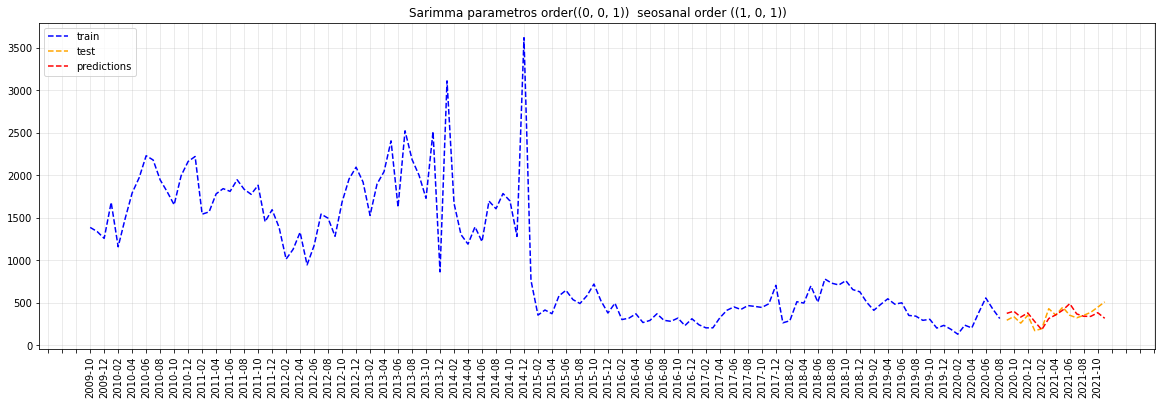

In [13]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(sarima_prediction):], sarima_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Sarimma parametros order({best_order_sarima})  seosanal order ({best_seasonal_order_sarima})")
plt.grid(alpha=0.3);

In [14]:
sarima_mse = mean_squared_error(y_true, sarima_prediction, squared=True)
sarima_mae = mean_absolute_error(y_true, sarima_prediction)
sarima_r2 = r2_score(y_true, sarima_prediction)
print(f'Mean Squared Error: {sarima_mse} ')
print(f'Mean Absolute Error: {sarima_mae}')
print(f'R2 Score: {sarima_r2}')

Mean Squared Error: 7118.920901082134 
Mean Absolute Error: 67.42114423959752
R2 Score: 0.11272271338481332



---
## SARIMAX - Uso de Variáveis Exógenas

Optamos por não evoluir nesse modelo e iniciar os testes com Redes Neurais

In [7]:
df_multivariate = df_oec_mpme[['desembolso', 'vendas', 'aprovacao',
       'ind_atv_econ', 'dif_custo_bndes_mercado']]

In [8]:
df_multivariate.head()

,desembolso,vendas,aprovacao,ind_atv_econ,dif_custo_bndes_mercado
data_base,,,,,
2009-10-01,1388.5,13123.0,1437.057832,129.78,-8.796206
2009-11-01,1339.9,13219.0,1497.107343,130.01,-9.062494
2009-12-01,1259.6,15104.0,1580.255803,131.36,-9.233439
2010-01-01,1682.7,11569.0,1853.163058,133.50,-9.156129
2010-02-01,1160.7,9581.0,1774.880889,135.18,-8.657825


In [9]:
df_multivariate.corr()

,desembolso,vendas,aprovacao,ind_atv_econ,dif_custo_bndes_mercado
desembolso,1.000000,0.785499,0.883498,0.569277,-0.744364
vendas,0.785499,1.000000,0.751808,0.576453,-0.492160
aprovacao,0.883498,0.751808,1.000000,0.516675,-0.734661
ind_atv_econ,0.569277,0.576453,0.516675,1.000000,-0.549939
dif_custo_bndes_mercado,-0.744364,-0.492160,-0.734661,-0.549939,1.000000


In [ ]:
y_train_exogeno[0]

In [10]:
feature_columns = ['vendas', 'aprovacao',
       'ind_atv_econ', 'dif_custo_bndes_mercado']
pred_column = 'desembolso'
X_test, y_train_endogeno, y_train_exogeno, y_test = split_train_test_multivariate_window_dataset(data_frame=df_multivariate,feature_columns=feature_columns, pred_column=pred_column,test_percentual_size=TEST_SPLIT_SIZE)

C:\Users\gdutr\AppData\Local\Temp/ipykernel_1936/778083698.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train_endogeno = np.array(test_endogeno_dataset_list)
C:\Users\gdutr\AppData\Local\Temp/ipykernel_1936/778083698.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train_exogeno = np.array(test_exogeno_dataset_list)


In [ ]:
best_order = (0,2,11)
best_seasonal_order  = (1,1,1)
best_seasonal_order_tuple = best_seasonal_order + (12,)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    start_time = time.time()
    prediction_list = []
    for step in range(len(y_train_endogeno)):
        mod = sm.tsa.statespace.SARIMAX(endog=y_train_endogeno[step], exog=y_train_exogeno[step],order=best_order, seasonal_order=best_seasonal_order_tuple)
        res = mod.fit(disp=False)
        prediction_list.append(res.forecast(steps=1))
    sarimax_prediction = np.array(prediction_list)  
    print(f'Tempo de execução {time.time() - start_time} segundos')